In [1]:
from src.config import DEVICE, CLASSES, NUM_CLASSES, BATCH_SIZE, NUM_EPOCHS, LEARNING_RATE, PRINT_FREQ, DATA_DIR, MODEL_PATH, THRESHOLD, INFERENCE_DIR, transform
from src.datasets import CustomDataset, InferenceDataset, collate_fn
from src.models import get_model, load_model_for_inference
from src.train import train_model
from src.evaluate import calculate_map, calculate_f1_per_class, visualize_metrics
from src.inference import run_inference
from src.visualize import visualize_predictions, analyze_detection_results

from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader, Subset
import os
from datetime import datetime
from copy import deepcopy
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import numpy as np
import seaborn as sns
import matplotlib.patches as patches
import cv2
import xml.etree.ElementTree as ET

In [2]:
full_dataset = CustomDataset(DATA_DIR, DATA_DIR, transform)

indices = list(range(len(full_dataset)))
train_idx, test_idx = train_test_split(indices, test_size=0.15, random_state=42)
train_idx, val_idx = train_test_split(train_idx, test_size=0.176, random_state=42)

train_dataset = Subset(full_dataset, train_idx)
val_dataset = Subset(full_dataset, val_idx)
test_dataset = Subset(full_dataset, test_idx)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

print(f"Dataset sizes: Train={len(train_dataset)}, Val={len(val_dataset)}, Test={len(test_dataset)}")

Dataset sizes: Train=654, Val=140, Test=141


In [4]:
model = get_model(NUM_CLASSES)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(params, lr=LEARNING_RATE, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=3
)

os.makedirs('saved_models', exist_ok=True)

best_map = 0.0
best_model_weights = None

train_losses = []
val_maps = []


model, train_losses, val_maps, best_model_weights = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=NUM_EPOCHS,
    device=DEVICE,
    print_freq=PRINT_FREQ,
    saved_models_dir='saved_models' 
)

Epoch: 1/30, Batch: 1/82, Loss: 18.5742
Epoch: 1/30, Batch: 21/82, Loss: 5.4970
Epoch: 1/30, Batch: 41/82, Loss: 3.2965
Epoch: 1/30, Batch: 61/82, Loss: 3.3593
Epoch: 1/30, Batch: 81/82, Loss: 3.6664
Epoch 1 Train Loss: 5.2780


C:\Users\MAFirsov\AppData\Roaming\Python\Python312\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)


Epoch 1 Validation mAP: 0.5773
Validation metrics: mAP@50=0.6112, mAP@75=0.5435
New best model saved with mAP 0.5773 at saved_models\best_model.pth
Epoch: 2/30, Batch: 1/82, Loss: 2.8067
Epoch: 2/30, Batch: 21/82, Loss: 2.5195
Epoch: 2/30, Batch: 41/82, Loss: 2.8050
Epoch: 2/30, Batch: 61/82, Loss: 1.8895
Epoch: 2/30, Batch: 81/82, Loss: 2.6080
Epoch 2 Train Loss: 2.4530
Epoch 2 Validation mAP: 0.7700
Validation metrics: mAP@50=0.7970, mAP@75=0.7431
New best model saved with mAP 0.7700 at saved_models\best_model.pth
Epoch: 3/30, Batch: 1/82, Loss: 1.9423
Epoch: 3/30, Batch: 21/82, Loss: 1.3465
Epoch: 3/30, Batch: 41/82, Loss: 1.5544
Epoch: 3/30, Batch: 61/82, Loss: 1.3824
Epoch: 3/30, Batch: 81/82, Loss: 1.2977
Epoch 3 Train Loss: 1.7793
Epoch 3 Validation mAP: 0.7994
Validation metrics: mAP@50=0.8445, mAP@75=0.7543
New best model saved with mAP 0.7994 at saved_models\best_model.pth
Epoch: 4/30, Batch: 1/82, Loss: 1.0986
Epoch: 4/30, Batch: 21/82, Loss: 1.1084
Epoch: 4/30, Batch: 41/82

In [5]:
test_metrics = calculate_map(model, test_loader, DEVICE)
test_map = test_metrics['map'].item()
print(f'\n=== Final Test Results ===')
print(f'Test mAP: {test_map:.4f}')
print(f'Test mAP@50: {test_metrics.get("map_50", torch.tensor(0.0)).item():.4f}')
print(f'Test mAP@75: {test_metrics.get("map_75", torch.tensor(0.0)).item():.4f}')
print()


=== Final Test Results ===
Test mAP: 0.9232
Test mAP@50: 0.9296
Test mAP@75: 0.9169



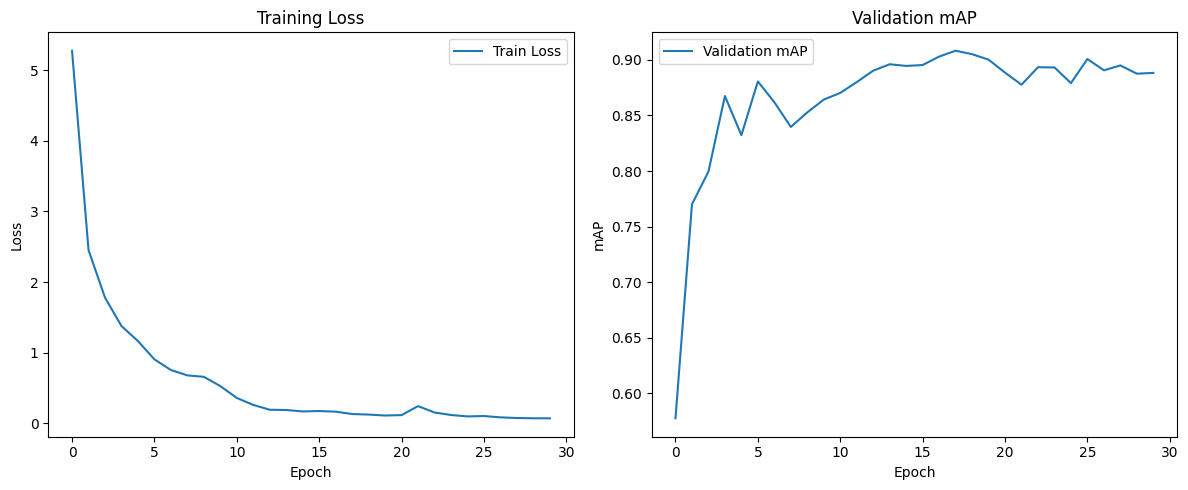

In [7]:
# Визуализация обучения
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_maps, label='Validation mAP')
plt.title('Validation mAP')
plt.xlabel('Epoch')
plt.ylabel('mAP')
plt.legend()

plt.tight_layout()
plt.savefig('training_metrics.png')
plt.show()

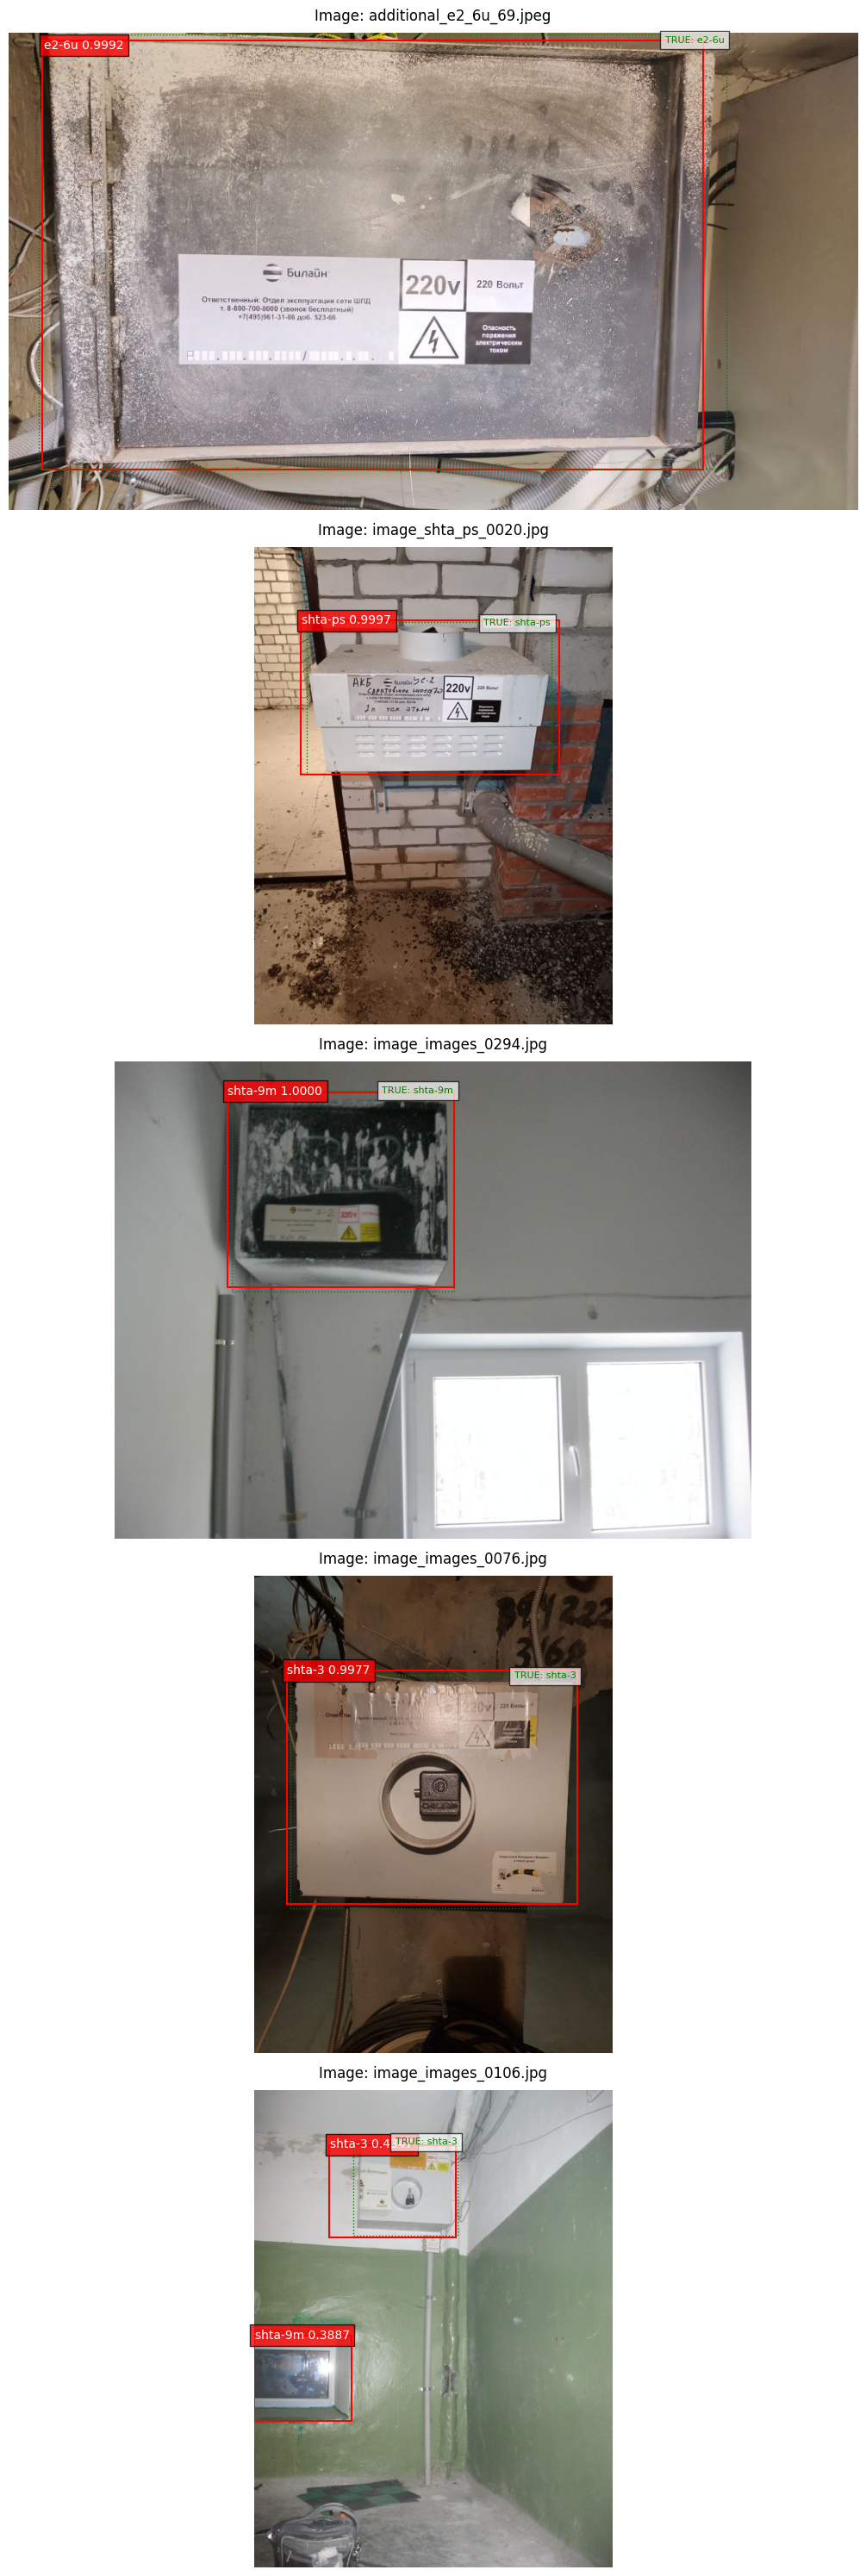

In [8]:
visualize_predictions(model, val_dataset, num_samples=5, threshold=0.3)

In [3]:
inference_dataset = InferenceDataset(
    img_dir=INFERENCE_DIR,
    transforms=transform
)
 
inference_loader = DataLoader(
    inference_dataset,
    batch_size=1,
    shuffle=False,
    collate_fn=collate_fn
)

model = load_model_for_inference(MODEL_PATH, NUM_CLASSES, DEVICE)

detection_results_path = r'C:\Users\MAFirsov\Nextcloud\python_projects\NETOLOGY\object_foto_dataset\models_selection\ssd320\detection_results'

print(f"Images to process: {len(inference_dataset)}")

df_results = run_inference(
    model=model,
    inference_loader=inference_loader,
    device=DEVICE,
    confidence_threshold=THRESHOLD,
    output_csv_path=os.path.join(detection_results_path, 'detection_results.csv')
)

Images to process: 935


Processing images: 100%|██████████| 935/935 [01:00<00:00, 15.42it/s]

Detection completed! Results saved to C:\Users\MAFirsov\Nextcloud\python_projects\NETOLOGY\object_foto_dataset\models_selection\ssd320\detection_results\detection_results.csv
Total objects detected: 1068



--- Analyzing Detection Results ---


c:\Users\MAFirsov\Nextcloud\python_projects\NETOLOGY\object_foto_dataset\models_selection\ssd320\src\visualize.py:123: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')


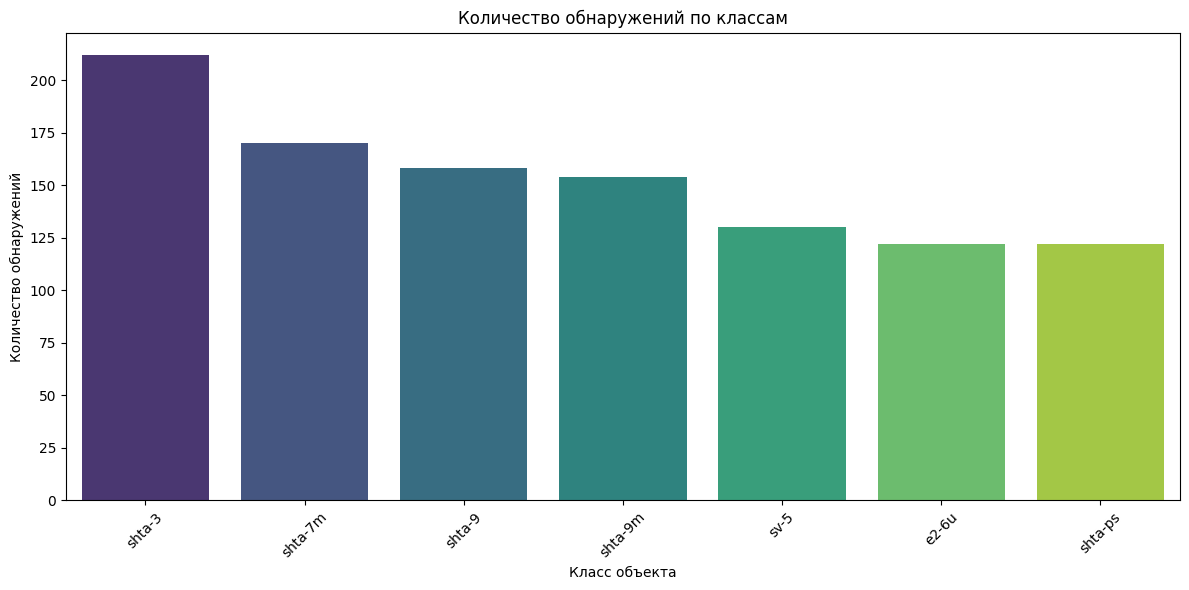


1. Количество обнаружений по классам:
class_name
shta-3     212
shta-7m    170
shta-9     158
shta-9m    154
sv-5       130
e2-6u      122
shta-ps    122
Name: count, dtype: int64


c:\Users\MAFirsov\Nextcloud\python_projects\NETOLOGY\object_foto_dataset\models_selection\ssd320\src\visualize.py:139: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=confidence_by_class.index, y=confidence_by_class.values, palette='coolwarm')


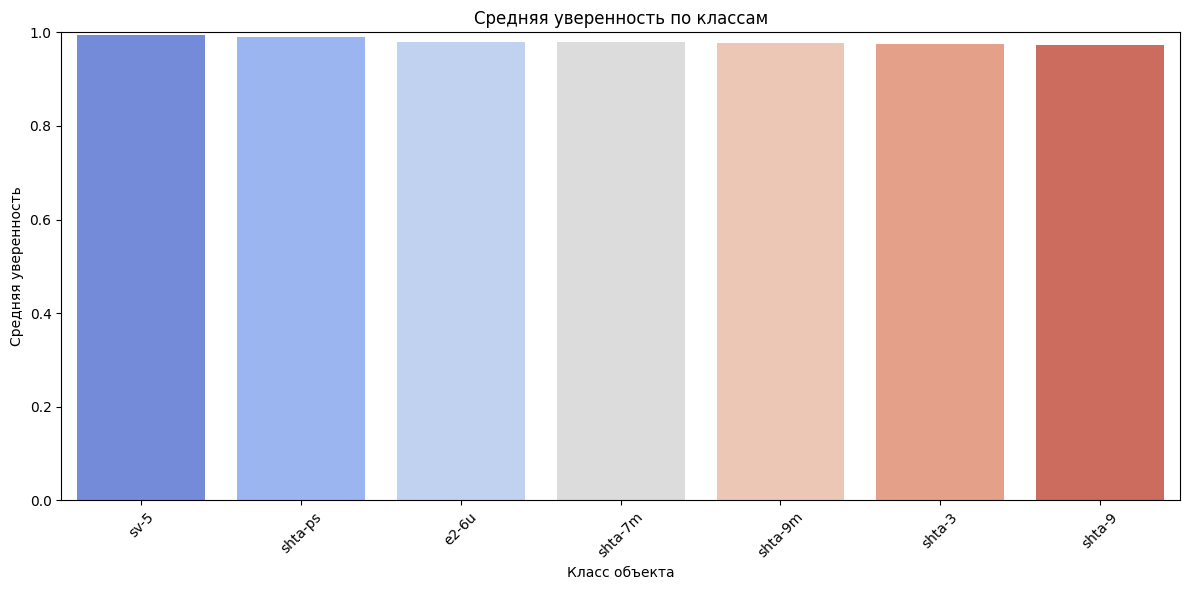


2. Средняя уверенность по классам:
class_name
sv-5       0.994628
shta-ps    0.990650
e2-6u      0.980176
shta-7m    0.978735
shta-9m    0.977392
shta-3     0.975105
shta-9     0.972792
Name: confidence, dtype: float32


c:\Users\MAFirsov\Nextcloud\python_projects\NETOLOGY\object_foto_dataset\models_selection\ssd320\src\visualize.py:178: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_results, x='class_name', y='width', palette='Set3')


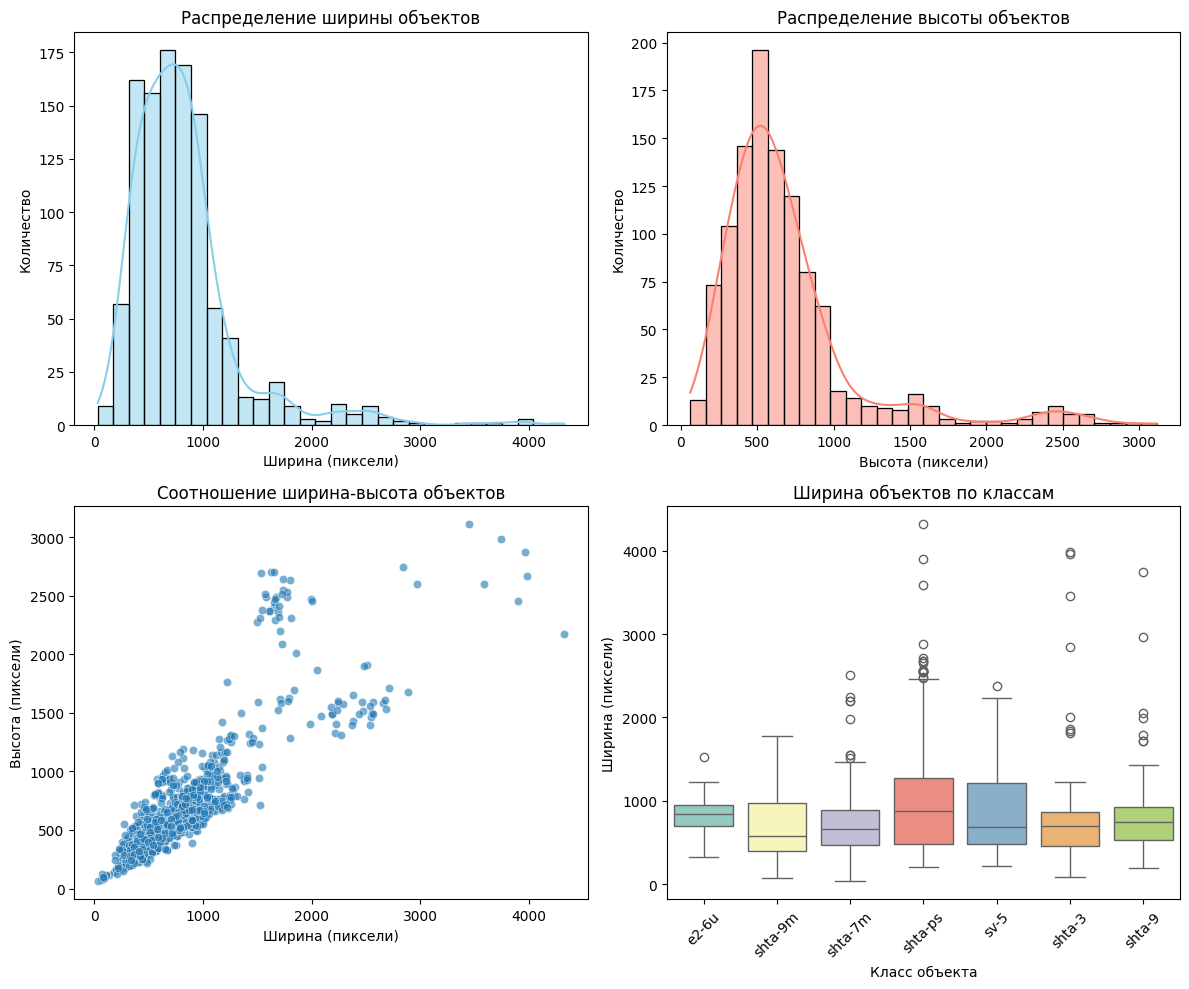


3. Статистика размеров объектов:
             width       height
count  1068.000000  1068.000000
mean    815.167603   683.757507
std     507.472931   463.240845
min      33.725327    60.462326
25%     495.199646   421.048767
50%     723.004913   570.589813
75%     942.887360   779.080765
max    4323.249512  3115.214111

4. Изображения без детекций: 1
Список сохранен в: C:\Users\MAFirsov\Nextcloud\python_projects\NETOLOGY\object_foto_dataset\models_selection\ssd320\detection_results_analysis\images_without_detections.csv

    Анализ результатов детекции:
    ------------------------------------
    1. Общее количество обнаруженных объектов: 1068
    2. Количество обработанных изображений: 935
    3. Изображений с детекциями: 934
    4. Изображений без детекций: 1
    5. Средняя уверенность по всем объектам: 0.9804
    6. Минимальная уверенность: 0.5013
    7. Максимальная уверенность: 1.0000

    Распределение по классам:
    class_name
shta-3     212
shta-7m    170
shta-9     158
shta

{'class_counts_plot': 'C:\\Users\\MAFirsov\\Nextcloud\\python_projects\\NETOLOGY\\object_foto_dataset\\models_selection\\ssd320\\detection_results_analysis\\class_counts.png',
 'confidence_by_class_plot': 'C:\\Users\\MAFirsov\\Nextcloud\\python_projects\\NETOLOGY\\object_foto_dataset\\models_selection\\ssd320\\detection_results_analysis\\confidence_by_class.png',
 'size_distribution_plot': 'C:\\Users\\MAFirsov\\Nextcloud\\python_projects\\NETOLOGY\\object_foto_dataset\\models_selection\\ssd320\\detection_results_analysis\\object_size_distribution.png',
 'analysis_report_txt': 'C:\\Users\\MAFirsov\\Nextcloud\\python_projects\\NETOLOGY\\object_foto_dataset\\models_selection\\ssd320\\detection_results_analysis\\analysis_report.txt',
 'images_without_detections_csv': 'C:\\Users\\MAFirsov\\Nextcloud\\python_projects\\NETOLOGY\\object_foto_dataset\\models_selection\\ssd320\\detection_results_analysis\\images_without_detections.csv'}

In [4]:
detection_results_analysis_path = r'C:\Users\MAFirsov\Nextcloud\python_projects\NETOLOGY\object_foto_dataset\models_selection\ssd320\detection_results_analysis'

analyze_detection_results(
    df_results=df_results,
    inference_dataset=inference_dataset,
    save_dir=detection_results_analysis_path
)

In [5]:
class_metrics, summary_metrics = calculate_f1_per_class(model, test_loader, DEVICE)

# Print results using the calculated metrics
print("\nДетальные метрики по классам:")
for class_id, metrics in class_metrics.items():
    class_name = CLASSES.get(class_id, f"Unknown_{class_id}")
    print(f"{class_name} (ID: {class_id}):")
    print(f"  F1-Score: {metrics['f1']:.4f}")
    print(f"  Precision: {metrics['precision']:.4f}")
    print(f"  Recall: {metrics['recall']:.4f}")
    print(f"  Support: {metrics['support']}")
    print()

print("\nИтоговые метрики по всем классам:")
print(f"Общее количество объектов: {summary_metrics['micro']['support']}")
print(f"True Positives (TP): {summary_metrics['total_tp']}")
print(f"False Positives (FP): {summary_metrics['total_fp']}")
print(f"False Negatives (FN): {summary_metrics['total_fn']}")
print()

print("Микро-усреднение (глобальный подсчет):")
print(f"  F1-Score: {summary_metrics['micro']['f1']:.4f}")
print(f"  Precision: {summary_metrics['micro']['precision']:.4f}")
print(f"  Recall: {summary_metrics['micro']['recall']:.4f}")
print()

print("Макро-усреднение (среднее по классам):")
print(f"  F1-Score: {summary_metrics['macro']['f1']:.4f}")
print(f"  Precision: {summary_metrics['macro']['precision']:.4f}")
print(f"  Recall: {summary_metrics['macro']['recall']:.4f}")
print()

print("Взвешенное усреднение (по количеству объектов):")
print(f"  F1-Score: {summary_metrics['weighted']['f1']:.4f}")
print(f"  Precision: {summary_metrics['weighted']['precision']:.4f}")
print(f"  Recall: {summary_metrics['weighted']['recall']:.4f}")


Детальные метрики по классам:
shta-9m (ID: 1):
  F1-Score: 0.8333
  Precision: 0.8000
  Recall: 0.8696
  Support: 23

shta-ps (ID: 2):
  F1-Score: 0.9091
  Precision: 0.9375
  Recall: 0.8824
  Support: 17

shta-7m (ID: 3):
  F1-Score: 0.8444
  Precision: 0.7308
  Recall: 1.0000
  Support: 19

e2-6u (ID: 4):
  F1-Score: 0.9231
  Precision: 0.9000
  Recall: 0.9474
  Support: 19

shta-9 (ID: 5):
  F1-Score: 0.8387
  Precision: 0.8667
  Recall: 0.8125
  Support: 32

shta-3 (ID: 6):
  F1-Score: 0.7246
  Precision: 0.6098
  Recall: 0.8929
  Support: 28

sv-5 (ID: 7):
  F1-Score: 0.9730
  Precision: 0.9474
  Recall: 1.0000
  Support: 18


Итоговые метрики по всем классам:
Общее количество объектов: 156
True Positives (TP): 141
False Positives (FP): 36
False Negatives (FN): 15

Микро-усреднение (глобальный подсчет):
  F1-Score: 0.8468
  Precision: 0.7966
  Recall: 0.9038

Макро-усреднение (среднее по классам):
  F1-Score: 0.8638
  Precision: 0.8274
  Recall: 0.9149

Взвешенное усреднение (по 

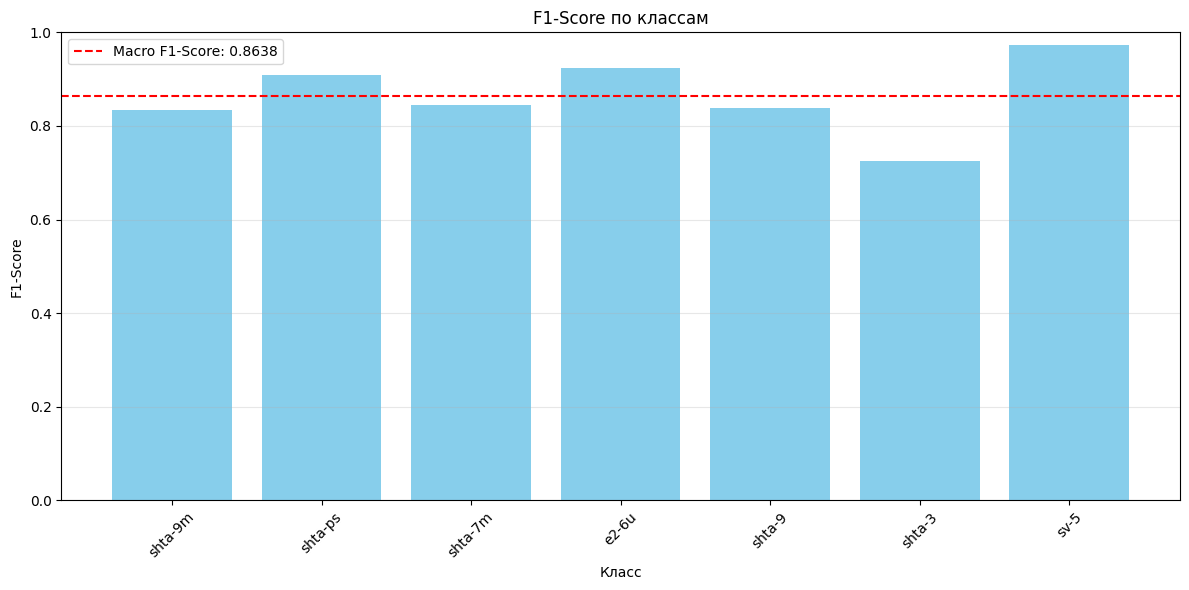

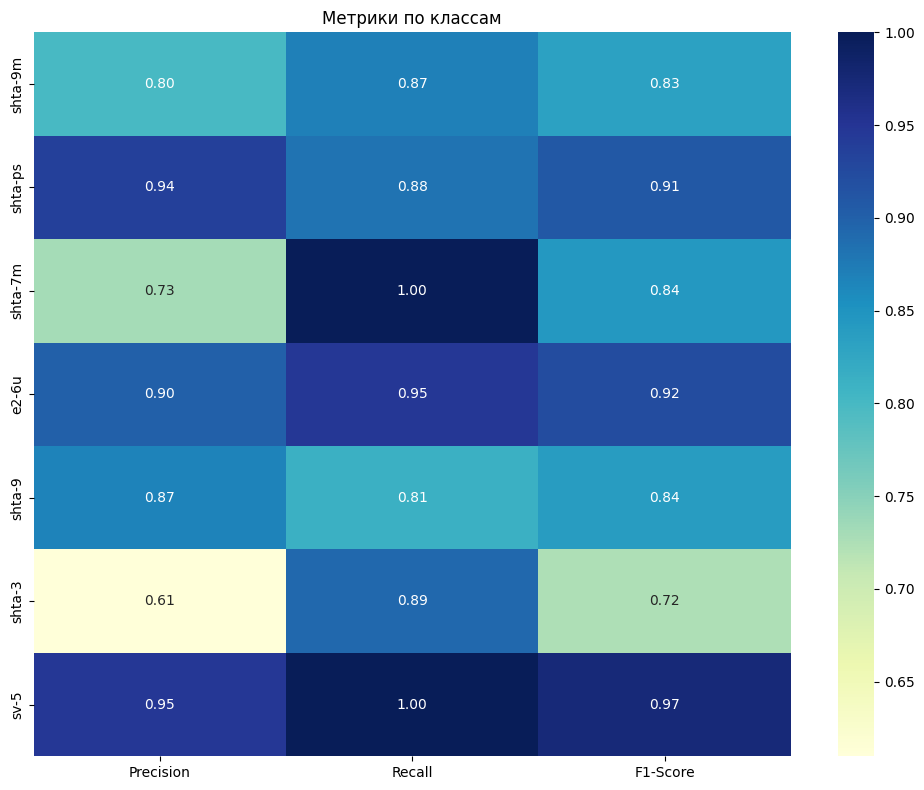

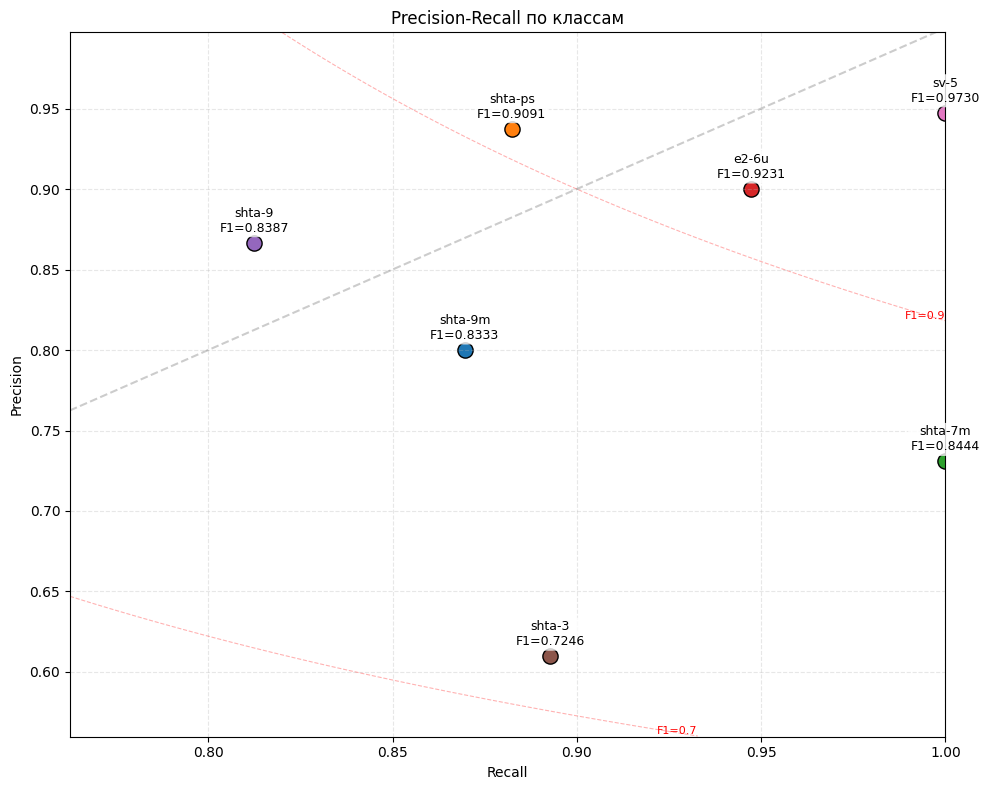

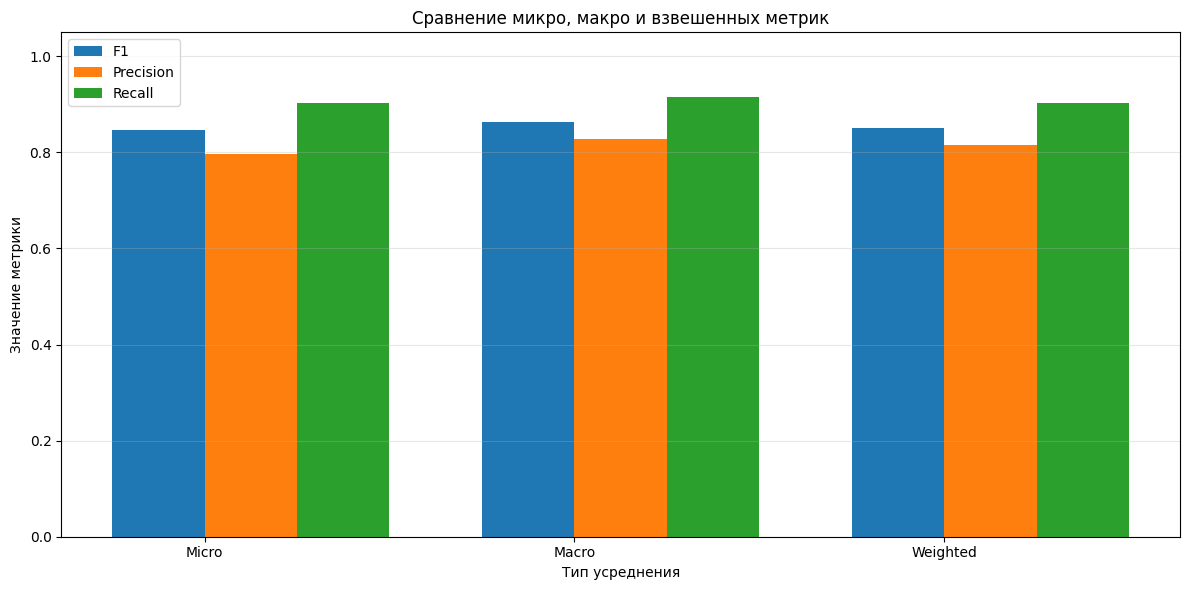


Visualization paths:
{'f1_by_class': 'C:\\Users\\MAFirsov\\Nextcloud\\python_projects\\NETOLOGY\\object_foto_dataset\\models_selection\\ssd320_1st_pr\\metrics_results\\f1_by_class.png', 'metrics_heatmap': 'C:\\Users\\MAFirsov\\Nextcloud\\python_projects\\NETOLOGY\\object_foto_dataset\\models_selection\\ssd320_1st_pr\\metrics_results\\metrics_heatmap.png', 'precision_recall': 'C:\\Users\\MAFirsov\\Nextcloud\\python_projects\\NETOLOGY\\object_foto_dataset\\models_selection\\ssd320_1st_pr\\metrics_results\\precision_recall.png', 'summary_metrics': 'C:\\Users\\MAFirsov\\Nextcloud\\python_projects\\NETOLOGY\\object_foto_dataset\\models_selection\\ssd320_1st_pr\\metrics_results\\summary_metrics.png', 'class_report_csv': 'C:\\Users\\MAFirsov\\Nextcloud\\python_projects\\NETOLOGY\\object_foto_dataset\\models_selection\\ssd320_1st_pr\\metrics_results\\metrics_report.csv', 'summary_report_csv': 'C:\\Users\\MAFirsov\\Nextcloud\\python_projects\\NETOLOGY\\object_foto_dataset\\models_selection\\ss

In [7]:
metrics_results_path = r'C:\Users\MAFirsov\Nextcloud\python_projects\NETOLOGY\object_foto_dataset\models_selection\ssd320_1st_pr\metrics_results'

visualization_paths = visualize_metrics(
    class_metrics=class_metrics,
    summary_metrics=summary_metrics,
    classes_dict=CLASSES,
    save_dir=metrics_results_path
)

print("\nVisualization paths:")
print(visualization_paths)